Ce travail à été réalisé en parallèlle à mon apprentissage du traitement des séries temporelles sur Coursera. J'ai mis en pratique mes connaissances acquises sur ce jeu de données trouvé sur Kaggle (jeu de données assez simple, avec une saisonalité claire et une stationarité).

Data : https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data

# Import des librairies

In [1]:
# Structure de données
import numpy as np
import pandas as pd

# Graphiques
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Traitement du signal
import scipy.signal as ss

# Modèle et évaluation
import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard

# Fixation de l'aléatoire
tf.random.set_seed(0)
np.random.seed(0)

# Dictionnaire des performances et des prédictions
prediction = dict()
performance = dict()
col = dict()

## Définition des méthodes

In [2]:
def plot_ts(time, series, label, start=0, end=None, c = 'blue', lw = 1.5):
    plt.plot(time[start:end], series[start:end], label=label, c = c, lw = lw)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label != None:
        plt.legend()
        
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

def evaluation(title, y_true, y_pred):
    print(str(title.center(100, '=')))
    print('MAE : ', tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy())
    print('RMSE : ', tf.keras.metrics.mean_squared_error(y_true, y_pred).numpy())
    
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def pred(model, data, window_size):
    prediction = []
    for time in range(validation.shape[0] - window_size):
        prediction.append(model.predict(data['meantemp'].values[time:time + window_size][np.newaxis]))
    return np.array(prediction)[:, 0, 0]

def windowed_dataset_conv(series, window_size, batch_size, shuffle_buffer = 1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series.values)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # shift = 1, on avance de 1 à chaque fois
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Créer window_size + 1 batch différents puis les applatis
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Split du dataset et visualisation du problème

Nous cherchons au travers de ce travail à prédire la température à Dehli sur l'année 2017. Nous disposons des données pour les années 2013 à 2016 pour l'entrainement et le début de 2017 pour la validation.

In [3]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
validation = pd.read_csv('DailyDelhiClimateTest.csv')

# Création d'une variable Time correspondant au numéro du jour, permettant une représentation graphique
train['Time'] = np.linspace(start = 0, stop = train.shape[0], num = train.shape[0], dtype = int)
validation['Time'] = np.linspace(start = 0, stop = validation.shape[0], num = validation.shape[0], dtype = int)

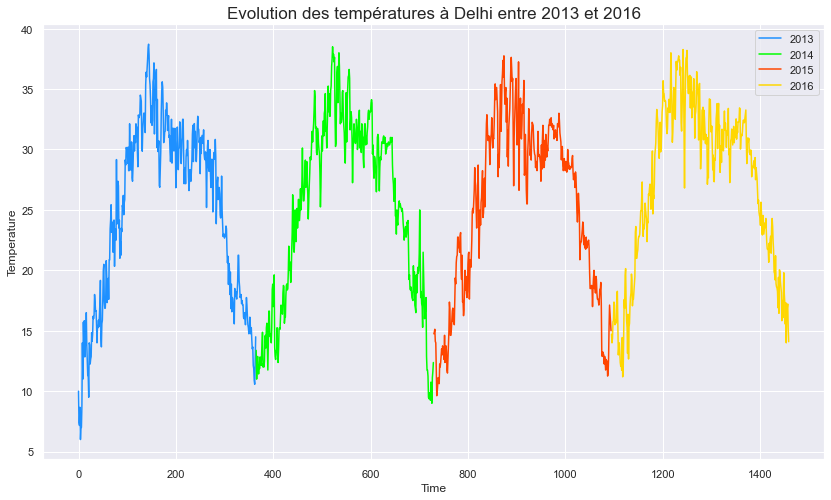

In [4]:
plt.figure(figsize = (14,8))
plot_ts(train['Time'], train['meantemp'], label = '2013', c = 'dodgerblue',  end = 365)
plot_ts(train['Time'], train['meantemp'], label = '2014', c = 'lime',  start = 365, end = 365*2)
plot_ts(train['Time'], train['meantemp'], label = '2015', c = 'orangered',  start = 365*2, end = 365*3)
plot_ts(train['Time'], train['meantemp'], label = '2016', c = 'gold',  start = 365*3, end = 365*4)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Evolution des températures à Delhi entre 2013 et 2016', fontsize = 17)
plt.show()

On observe une saisonalité par année, chaque année un nouveau cycle similaire aux années précédente se réalise. Ainsi, pour prédire le nième jour d'une année future, il est possible de se baser sur les jours des années précédentes.

# Prédiction via méthodes statistiques

Le premier moyen de prédiction est de réaliser une moyenne mobile (de fenêtre 20) sur l'année 2013 et d'utiliser ensuite la valeur de cette moyenne mobile comme prévision pour l'année 2017. La moyenne mobile consiste à prendre les données sur un certain nombre de jours (20 pour notre cas) précédent un jour $t$, et d'en faire la moyenne. Le résultat sera alors notre prédiction. <br>
Mathématiquement cela donne : $$\Large \hat{y}_t = \frac{1}{19} \sum_{i=t-20}^{t-1} x_i$$ avec $\hat{y}_t$ la valeur de notre prédiction pour un jour $t$ donné<br>
La 2e méthode est similaire à la première, sauf qu'au lieu de ne considérer que la moyenne mobile pour l'année 2013, on considère la moyenne des moyenne mobiles par année. Soit mathématiquement : <br>
$$\Large \hat{y}_t = \frac{1}{19} \sum_{i=t-20}^{t-1} \bar{X_i}$$<br> ou $\bar{X_i}$ fait référence à la moyenne des éléments du vecteur $X_i$ contenant les valeurs des années précédents 2016, pour un jour $i$ fixé on à : $X = (x_{2013}, x_{2014}, x_{2015}, x_{2016})$. <br>
La 3e méthode consiste à utiliser l'algorithme de Savitzky-Golay, approximant la courbe par des polynomes sur une fenêtre donnée (de façon similaire à la moyenne mobile qui est un cas particulier de l'algorithme où le polynôme est de degré nul). Dans notre cas, le choix d'un polynôme de second degré à été retenu avec une fenêtre de 19 (la fenêtre doit être de taille impaire).

In [5]:
moving_avg = moving_average_forecast(train['meantemp'], 20)
# On ne garde que les mêmes jours que dans le validation set
moving_avg_validation = moving_avg[:validation.shape[0]]

mm = list()
temp_moyenne = list()

for i in range(345):
    l = []
    t = []
    for j in range(4):
        l.append(moving_avg[i+365*j]) # moyenne des moving average
        t.append(train['meantemp'][i+365*j]) # moyenne des valeurs pour les 3 ans pour le Savitsky-Golay
    mm.append(np.mean(l))
    temp_moyenne.append(np.mean(t))
    
mm_forecast_validation = mm[:validation.shape[0]]
sav_gol_forecast = ss.savgol_filter(temp_moyenne, window_length = 19, polyorder = 2)[:validation.shape[0]]

## Visualisation et analyse des résultats

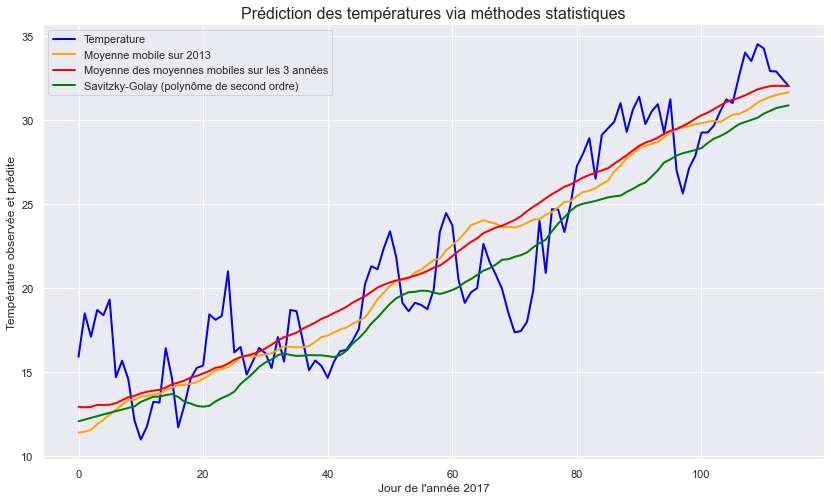

In [6]:
plt.figure(figsize=(14, 8))
plt.title('Prédiction des températures via méthodes statistiques', fontsize = 16)
plot_ts(validation['Time'], validation['meantemp'], 'Temperature', lw = 2)
plot_ts(validation['Time'], moving_avg_validation, 'Moyenne mobile sur 2013', c = 'orange', lw = 2)
plot_ts(validation['Time'], mm_forecast_validation, 'Moyenne des moyennes mobiles sur les 3 années',c = 'red', lw = 2)
plot_ts(validation['Time'], sav_gol_forecast, 'Savitzky-Golay (polynôme de second ordre)' , c = 'green', lw = 2)
plt.xlabel('Jour de l\'année 2017')
plt.ylabel('Température observée et prédite')
plt.show()

On observe que la moyenne mobile semble être la plus constante, elle semble être pertinente pour saisir la tendance générale des données. Calculons maintenant les erreurs relatives à chaque prédiction

*Petit point sur les métriques d'erreurs utilisées :*<br>
La **MAE (Mean Absolute Error ou erreur en valeur absolue moyenne)** correspond à la moyenne des erreurs en valeur absolue. L'idée est de mesurer une erreur (l'écart entre ce qui est prédit et observé) moyenne. On passe par la valeur absolue pour éviter les effets de compensation (eviter qu'une erreur négative compense une erreur positive). Mathématiquement cela donne : <br>
$$\Large MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i| $$ <br>

La **RMSE (Root Mean Squared Error ou erreur quadratique moyenne)** correspond à la moyenne des erreurs au carré. L'idée est la même que pour la MAE, à savoir calculer une "erreur moyenne". Toutefois on ne passe pas par la valeur absolue mais par le carré. On passe ensuite à la racine pour remettre à la même unité. La conséquence est que la RMSE va pénaliser plus fortement les gros écarts. Ainsi, si la MAE et la RMSE sont similaires, cela signifie que les écarts entre la prédiction et la réalité sont faibles. Toutefois si la RMSE est plus grande que la MAE, cela signifie qu'il y'a des grands écarts dans les erreurs observées. Mathématiquement cela donne : <br>
$$\Large RMSE = \sqrt{\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}} $$ <br>

Pour notre travail, nous ne souhaitons pas particulièrement pénaliser les grands écarts, nous nous focaliserons donc sur la MAE principalement.

In [7]:
evaluation(" Moyenne mobile sur 2013 : ", validation['meantemp'], moving_avg_validation)
evaluation(" Moyenne des moyennes mobiles sur les 3 années : ", validation['meantemp'], mm_forecast_validation)
evaluation(" Savitzky-Golay : ", validation['meantemp'], sav_gol_forecast)

==================================== Moyenne mobile sur 2013 : =====================================
MAE :  2.222154836997758
RMSE :  7.613043897492471
========================= Moyenne des moyennes mobiles sur les 3 années : ==========================
MAE :  2.134936689343755
RMSE :  6.89246266143483
========================================= Savitzky-Golay : =========================================
MAE :  2.318399817371752
RMSE :  8.398192437885006


Au vu des résultats, l'algorithme de Savitzky-Golay est le moins bon pour faire de la prédiction. En revanche, la méthode de la moyenne des moyennes mobiles des 3 années semble bien fonctionner avec un écart moyen de 2.13 °C.

## Differenciation

Une autre méthode utilisable est la différenciation : Cela consiste à calculer la différence entre les valeurs d'une année sur l'autre. L'idée est ici de supprimer la tendance et la saisonnalité. Voici le résultat lorsque l'on soustrait les températures de 2016 aux températures de 2013.

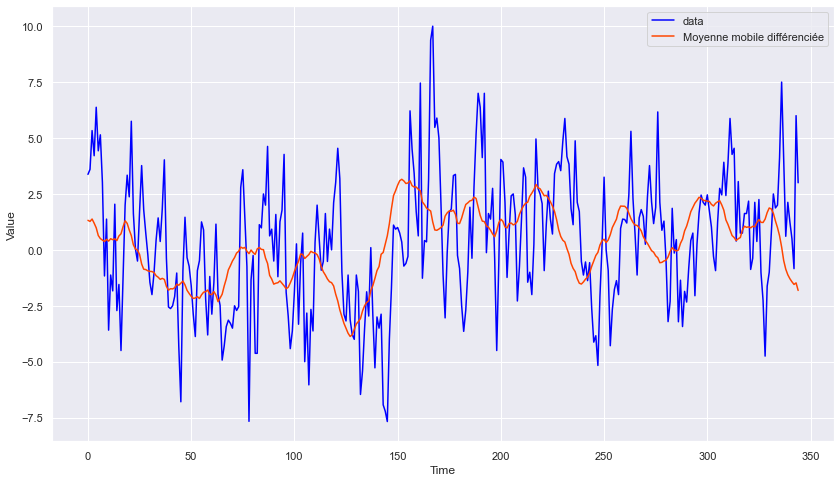

In [8]:
diff_series = (train['meantemp'][365:].values - train['meantemp'][:-365].values)[:365]
diff_time = train['Time'][:365]
diff_moving_avg = moving_average_forecast(diff_series, 20)

plt.figure(figsize=(14, 8))
plot_ts(diff_time[:345], diff_series[:345], 'data')
plot_ts(diff_time[:345], diff_moving_avg[:345], 'Moyenne mobile différenciée', c = 'orangered')
plt.show()

En ajoutant la moyenne mobile des données différenciées à nos prévisions précédentes, nous pouvons espérer gagner en précision sur la prédiction réalisée.

In [9]:
diff_moving_avg_mm_forecast = mm_forecast_validation + diff_moving_avg[:validation.shape[0]]
diff_moving_avg_forecast = moving_avg_validation + diff_moving_avg[:validation.shape[0]]
diff_sav_gol_forecast = sav_gol_forecast + diff_moving_avg[:validation.shape[0]]

## Visualisation et analyse des résultats

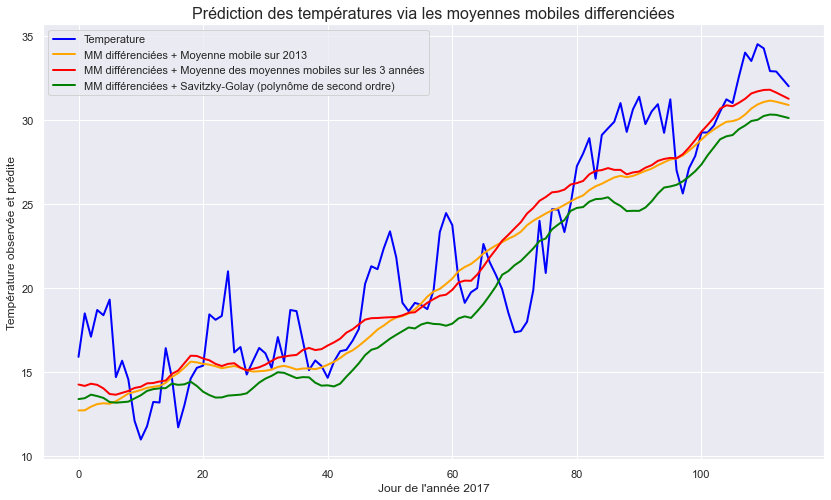

In [10]:
plt.figure(figsize=(14, 8))
plt.title('Prédiction des températures via les moyennes mobiles differenciées', fontsize = 16)
plot_ts(validation['Time'], validation['meantemp'], 'Temperature', lw = 2)
plot_ts(validation['Time'], diff_moving_avg_forecast, 'MM différenciées + Moyenne mobile sur 2013', c = 'orange', lw = 2)
plot_ts(validation['Time'], diff_moving_avg_mm_forecast, 'MM différenciées + Moyenne des moyennes mobiles sur les 3 années',c = 'red', lw = 2)
plot_ts(validation['Time'], diff_sav_gol_forecast, 'MM différenciées + Savitzky-Golay (polynôme de second ordre)',c = 'green', lw = 2)
plt.xlabel('Jour de l\'année 2017')
plt.ylabel('Température observée et prédite')
plt.show()

In [11]:
evaluation(" MM + Moyenne mobile sur 2013 : ", validation['meantemp'], diff_moving_avg_forecast)
evaluation(" MM + Moyenne des moyennes mobiles sur les 3 années : ", validation['meantemp'], diff_moving_avg_mm_forecast)
evaluation(" Diff MM + Savitzky-Golay (polynôme de second ordre) : ", validation['meantemp'], diff_sav_gol_forecast)

prediction['Moyenne mobile'] = diff_moving_avg_mm_forecast
col['Moyenne mobile'] = 'red'

================================== MM + Moyenne mobile sur 2013 : ==================================
MAE :  2.1466937294537436
RMSE :  7.440908715834771
======================= MM + Moyenne des moyennes mobiles sur les 3 années : =======================
MAE :  2.017200708768289
RMSE :  6.549686873850657
====================== Diff MM + Savitzky-Golay (polynôme de second ordre) : =======================
MAE :  2.7397482896813665
RMSE :  10.69860123726776


Mis à part pour l'algorithme de Savitzky-Golay, l'utilisation des moyennes mobiles différenciées à permis une légère augmentation des performances sur nos prédictions. En utilisant de simples méthodes statistiques, notre meilleur résultat est un écart moyen de prévision de 2°C.

# Régression linéaire simple avec TensorFlow

Dans un premier temps, nous allons créer un réseau de neurones très simple, prenant en entrée un certain nombre de variables, leur associant ensuite un poids et sommant l'ensemble des valeurs des variables multipliées par leurs poids respectifs. Ce processus est en fait la même chose qu'une régression linéaire classique.

Dans notre cas, nous ne disposons pas de variables classiques mais d'une seule variable évoluant de façon journalière. L'idée du modèle va alors être de prendre un jour, disons le jour $t$ de l'année et de créer une fenêtre de 20 jours précédent ce jour $t$. Les températures pour les 20 derniers jours précédent le jour $t$ constitueront alors nos variables d'entrée et la prédiction sera la température du jour $t$. On associera donc un poids (nommé $w$) à chacun des 20 jours précédents le jour étudié et la prédiction sera la somme des températures journalières pondérées par ces poids. Mathématiquement on aura :

$$\Large h_t(x) = w_0 + \sum_{i=t-20}^{t-1} x_iw_i$$

## Définition des hyperparamètres et modelisation

In [12]:
window_size = 20
batch_size = 64
# Comme précédemment, on prend une fenêtre de 20 jours pour prédire le 21e jour
shuffle_buffer_size = train.shape[0]

In [13]:
dataset = windowed_dataset(train['meantemp'], window_size, batch_size, shuffle_buffer_size)
# Permet la mise au bon format des données pour la modelisation

# Création du modèle
reg_lin = tf.keras.layers.Dense(1, input_shape=[window_size])
lr = tf.keras.models.Sequential([reg_lin])

lr.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9, nesterov = True),
             metrics=["mae"])
# La fonction de coût utilisée est la MSE, et l'optimisation est faite via la descente de gradient stochastique
# Le momentum de Nesterov est utilisé, pour éviter que la descente de gradient ne stagne dans des minimums locaux
history_lr = lr.fit(dataset, epochs=400, verbose=0)
performance['Linear Regression'] = history_lr.history['mae']

print("Coefficients de la régression linéaire : {}".format(reg_lin.get_weights()))

Coefficients de la régression linéaire : [array([[ 0.01392752],
       [-0.29850197],
       [ 0.20230722],
       [ 0.09904023],
       [ 0.04170307],
       [ 0.0356396 ],
       [-0.39479512],
       [ 0.34974742],
       [-0.03532773],
       [-0.14399363],
       [ 0.29439023],
       [ 0.10028131],
       [-0.3945879 ],
       [ 0.38588423],
       [-0.30471662],
       [ 0.46748465],
       [-0.15017417],
       [ 0.36507955],
       [ 0.05426132],
       [ 0.31023997]], dtype=float32), array([0.01105401], dtype=float32)]


## Visualisation et analyse des résultats

In [14]:
lr_forecast = pred(lr, validation, window_size)

In [15]:
val = validation[:-window_size]

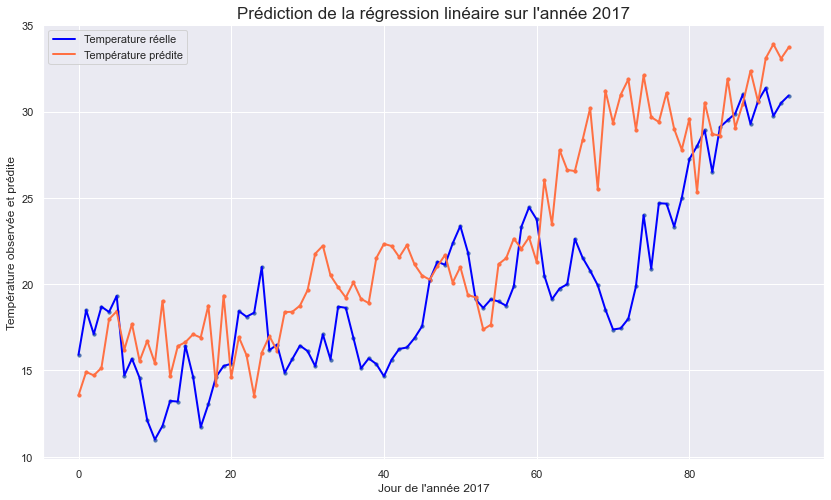

In [16]:
plt.figure(figsize = (14,8))
plt.title('Prédiction de la régression linéaire sur l\'année 2017', fontsize = 17)
plot_ts(val['Time'], val['meantemp'], 'Temperature réelle', lw = 2)
plt.scatter(val['Time'], val['meantemp'], s = 10)
plot_ts(val['Time'], lr_forecast, 'Température prédite', c = '#ff7043', lw = 2)
plt.scatter(val['Time'], lr_forecast, c = '#ff7043', s = 10)
plt.xlabel('Jour de l\'année 2017')
plt.ylabel('Température observée et prédite')
plt.show()

In [17]:
evaluation(" Régression Linéaire : ", val['meantemp'], lr_forecast)
prediction['Regression Linéaire'] = lr_forecast
col['Linear Regression'] = "#ff7043"

====================================== Régression Linéaire : =======================================
MAE :  3.7344582
RMSE :  22.96039


On voit bien ici la pénalisation faite par la RMSE comparée à la MAE.

# Réseau de neurones profonds

Pour comprendre rapidement le fonctionnement des réseaux de neurones nous allons nous baser sur l'image suivante :

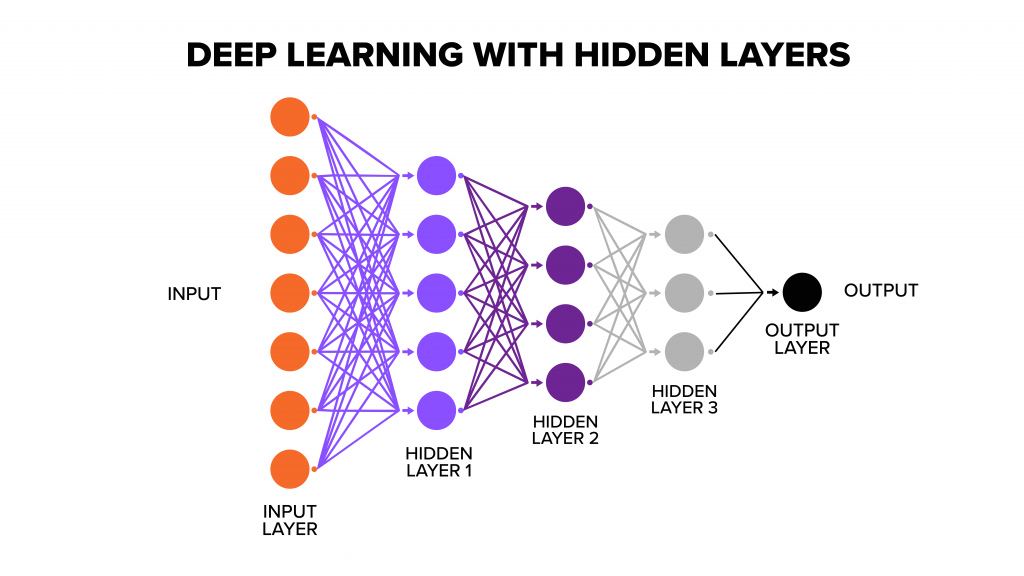

In [18]:
Image(filename='dnn.png') 

La couche d'entrée (Input Layer) correspond dans notre cas aux 20 jours précédent le jour $t$ que nous cherchons à prédire. On vient donc rentrer la température des 20 jours précédents le jour $t$ dans le réseau et il en ressort la température prédite pour le jour $t$. Notre modèle comporte 5 couches cachées (Hidden Layer) composées chacune de 20 neurones et d'une couche de sortie. Le fonctionnement d'un neurone dans la couche cachée est le suivant. Chaque neurone est relié à tous les neurones de la couche précédent, cela correspond aux "variables d'entrée" du neurone. Le neurone associe un poids à chacune des valeurs des variables d'entrée (comme le ferait une régression linéaire). Suite à cela, le neurone fait passer la somme des variables pondérées par une fonction d'activation et envoie le résultat aux neurones de la couche suivante comme variable d'entrée du prochain neurone. Il existe pléthore de fonctions d'activations, vous en trouverez une liste ici : https://fr.wikipedia.org/wiki/Fonction_d%27activation. Dans notre cas, nous utilisons la fonction RELU (Rectified Linear Unit) à chaque couche. Mathématiquement, la valeur de sortie d'un neurone peut s'écrire de la façon suivante : <br>

$$ \Large \phi(\sum_{i=1}^n x_i w_i)$$ ou $\phi$ correspond à la fonction d'activation, $x_i$ correspond à la valeur de la variable d'entrée $i$ et $w_i$ à son poids associé. On considère ici qu'il y'a $n$ variables d'entrée différentes pour le neurone. <br>
Pour notre réseau de neurones, la fonction RELU est utilisée à chaque couche. On peut donc réecrire l'équation de la valeur de sortie d'un neurone comme suit : <br>
$$\large max(0 , \sum_{i=1}^n x_i w_i)$$

Un réseau de neurones profond correspond à un enchainement de sommations pondérées des valeurs des neurones de la couche précédente sur lesquels on applique une fonction mathématique. Entrainer un réseau de neurones profond, revient à ajuster les poids du réseau pour que le résultat colle le plus possible aux observations.

In [19]:
dnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Tensorboard
log_dir = "logs/fit/" + 'Artificial Neural Network'
my_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9, nesterov = True)
dnn.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
dnn_history = dnn.fit(dataset, epochs=400, callbacks=my_callbacks, verbose=0)

performance['Deep Neural Network'] = dnn_history.history['mae']

## Visualisation et analyse des résultats

In [20]:
dnn_forecast = pred(dnn, validation, window_size)

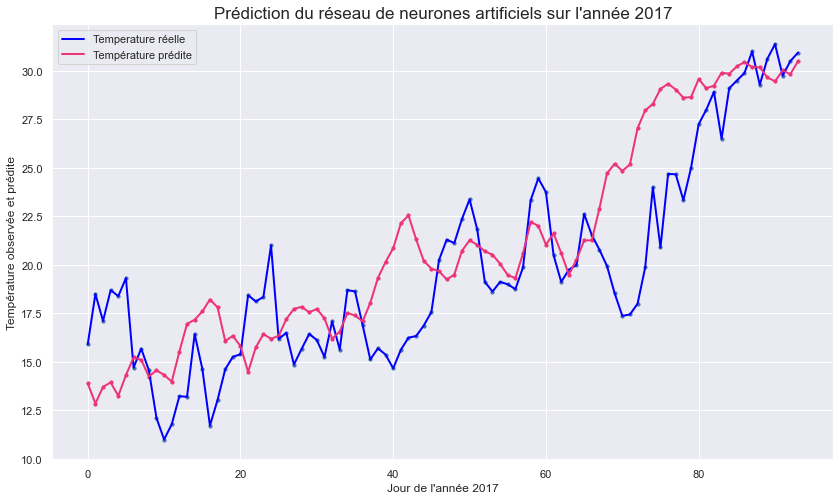

In [21]:
plt.figure(figsize = (14,8))
plt.title('Prédiction du réseau de neurones artificiels sur l\'année 2017', fontsize = 17)

# plot observée
plot_ts(val['Time'], val['meantemp'], 'Temperature réelle', lw = 2)
plt.scatter(val['Time'], val['meantemp'], s = 10)

# plot prédiction
plot_ts(val['Time'], dnn_forecast, 'Température prédite', c = '#ee3377', lw = 2)
plt.scatter(val["Time"], dnn_forecast, color = '#ee3377', s = 10)

# titre des axes
plt.xlabel('Jour de l\'année 2017')
plt.ylabel('Température observée et prédite')
plt.show()

In [22]:
evaluation(" Deep Neural Network : ", val['meantemp'], dnn_forecast)
prediction['Deep Neural Network'] = dnn_forecast
col['Deep Neural Network'] = "#ee3377"

====================================== Deep Neural Network : =======================================
MAE :  2.6155708
RMSE :  11.625355


On observe une meilleure performance que pour la régression linéaire. Il serait possible d'ajuster les hyperparamètres ou la structure du modèle pour obtenir d'encore meilleurs résultats, mais l'objet de ce travail est plutôt de tester différentes techniques permettant la prédiction de séries temporelles.

# Réseau de neurones récurrents

Sans rentrer dans les détails, le réseau de neurones profond considère chaque variable comme ayant un poids égal. Or dans notre cas, il ferait sens d'induire au sein du réseau un ordre d'importance. En effet, la température de la veille doit avoir une plus grande importance dans la prédiction du lendemain que la température d'il y'a 15 jours. Cela est possible via le type de réseau que nous allons implémenter ici, le réseau de neurones récurrent.

In [23]:
rnn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Tensorboard
log_dir = "logs/fit/" + 'Reccurrent Neural Network'
my_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]


optimizer = tf.keras.optimizers.SGD(learning_rate=10e-6, momentum=0.9)
rnn.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history_rnn = rnn.fit(dataset,callbacks = my_callbacks, epochs=400, verbose = 0)
performance['Recurrent Neural Network'] = history_rnn.history['mae']

## Visualisation et analyse des résultats

In [24]:
prediction_rnn = pred(rnn, validation, window_size)

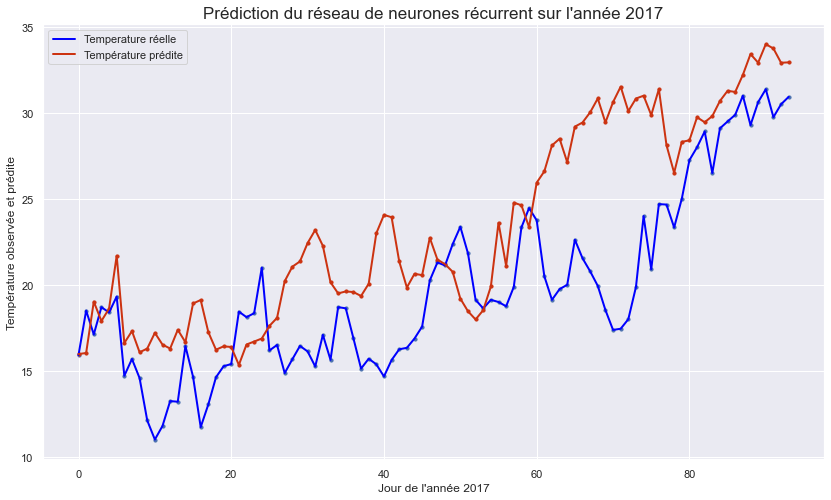

In [25]:
plt.figure(figsize = (14,8))
plt.title('Prédiction du réseau de neurones récurrent sur l\'année 2017', fontsize = 17)

# plot observée
plot_ts(val['Time'], val['meantemp'], 'Temperature réelle', lw = 2)
plt.scatter(val['Time'], val['meantemp'], s = 10)

# plot prédiction
plot_ts(val['Time'], prediction_rnn, 'Température prédite', c = '#cc3311', lw = 2)
plt.scatter(val["Time"], prediction_rnn, color = '#cc3311', s = 10)

# titre des axes
plt.xlabel('Jour de l\'année 2017')
plt.ylabel('Température observée et prédite')
plt.show()

In [26]:
evaluation(" Réseau de neurones récurrent : ", val['meantemp'], prediction_rnn)
prediction['Recurrent Neural Network'] = prediction_rnn
col['Recurrent Neural Network'] = "#cc3311"

================================== Réseau de neurones récurrent : ==================================
MAE :  4.0617313
RMSE :  26.753754


# Long Short Term Memory

La problématique des RNN est qu'il n'y a pas vraiment de mémoire à long terme. Les valeurs des jours précédents sont vite "oubliées" par le réseau. Le LSTM est une variante du réseau de neurones récurrent qui vient solutionner ce problème.

In [27]:
lstm = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Tensorboard
log_dir = "logs/fit/" + 'Long Short Term Memory'
my_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]


lstm.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=["mae"])
lstm_history = lstm.fit(dataset,epochs=400, callbacks = my_callbacks, verbose=0)

performance['LSTM'] = lstm_history.history['mae']

## Visualisation et analyse des résultats

In [28]:
prediction_lstm = pred(lstm, validation, window_size)

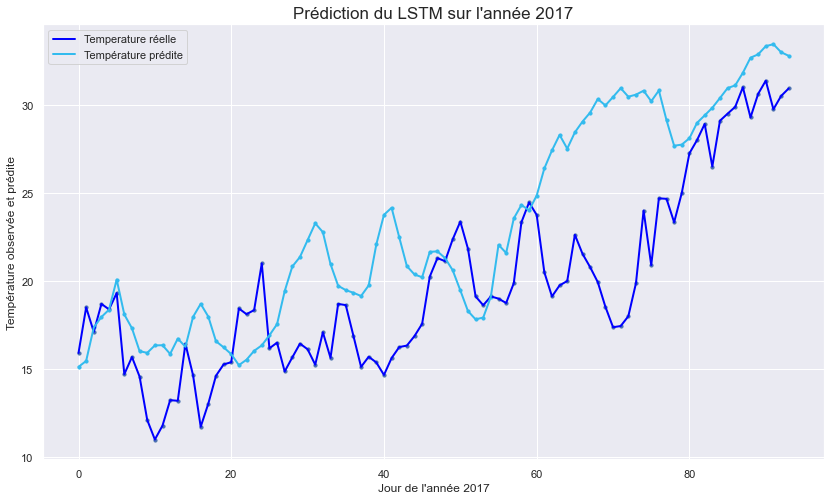

In [29]:
plt.figure(figsize = (14,8))
plt.title('Prédiction du LSTM sur l\'année 2017', fontsize = 17)

# plot observée
plot_ts(val['Time'], val['meantemp'], 'Temperature réelle', lw = 2)
plt.scatter(val['Time'], val['meantemp'], s = 10)

# plot prédiction
plot_ts(val['Time'], prediction_lstm, 'Température prédite', c = '#33bbee', lw = 2)
plt.scatter(val["Time"], prediction_lstm, color = '#33bbee', s = 10)

# titre des axes
plt.xlabel('Jour de l\'année 2017')
plt.ylabel('Température observée et prédite')
plt.show()

In [30]:
evaluation(" LSTM : ", val['meantemp'], prediction_lstm)
prediction['LSTM'] = prediction_lstm
col['LSTM'] = '#33bbee'

============================================== LSTM : ==============================================
MAE :  3.912898
RMSE :  25.632534


# Réseau de neurones à convolutions

Le dernier modèle est un modèle combinant les LSTM avec une couche de convolution. Les couches de convolutions permettent d'identifier certains patterns pour pouvoir les reproduire. C'est une technologie issue des techniques de reconnaissance d'image. Voyons ce que cela donne pour notre problématique :

In [31]:
window_size_convnet = 64
batch_size_convnet = 256

train_set_conv = windowed_dataset_conv(train['meantemp'], window_size_convnet, batch_size)

convnet = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

# Tensorboard
log_dir = "logs/fit/" + 'Modèle final'
my_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]


convnet.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

cnn_history = convnet.fit(train_set_conv, epochs=400, callbacks = my_callbacks, verbose = 0)
performance['Convnet'] = cnn_history.history['mae']

In [32]:
convnet_forecast = model_forecast(convnet, validation['meantemp'].values[..., np.newaxis], window_size_convnet)
convnet_forecast = convnet_forecast.flatten()

## Visualisation et analyse des résultats

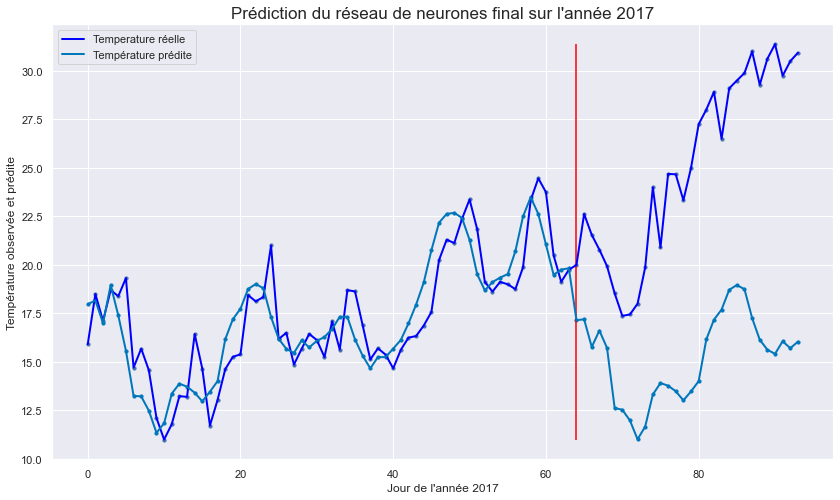

In [33]:
plt.figure(figsize = (14,8))
plt.title('Prédiction du réseau de neurones final sur l\'année 2017', fontsize = 17)

# plot observée
plot_ts(val['Time'], val['meantemp'], 'Temperature réelle', lw = 2)
plt.scatter(val['Time'], val['meantemp'], s = 10)

# plot prédiction
plot_ts(val['Time'], convnet_forecast[:val.shape[0]], 'Température prédite', c = '#0077bb', lw = 2)
plt.scatter(val["Time"], convnet_forecast[:val.shape[0]], color = '#0077bb', s = 10)

# plot ligne verticale
plt.vlines(64, 
          ymin = min([min(convnet_forecast[:val.shape[0]]),min(val['meantemp'])]), 
          ymax = max([max(convnet_forecast[:val.shape[0]]),max(val['meantemp'])]), color = 'red')

# titre des axes
plt.xlabel('Jour de l\'année 2017')
plt.ylabel('Température observée et prédite')
plt.show()

On observe une excellente prédiction pour les premiers jours et une prédiction beaucoup moins bonne pour les jours après le 64e jour.

In [34]:
evaluation(" Convolution Network (total) : ", val['meantemp'], convnet_forecast[:val.shape[0]])
evaluation(" Convolution Network (pré ligne rouge) : ", val['meantemp'][:64], convnet_forecast[:64])
prediction['Convnet'] = convnet_forecast[:val.shape[0]]
col['Convnet'] = '#0077bb'

================================== Convolution Network (total) : ===================================
MAE :  3.9809442
RMSE :  36.762756
============================= Convolution Network (pré ligne rouge) : ==============================
MAE :  1.2478933
RMSE :  2.4398432


# Synthèse finale des résultats obtenus

In [35]:
results = pd.DataFrame(index = ['MAE', 'RMSE'])
for k,v in prediction.items():
    results[k] = [keras.metrics.mean_absolute_error(val['meantemp'], v[:val.shape[0]]).numpy(), np.sqrt(keras.metrics.mean_squared_error(val['meantemp'], v[:val.shape[0]]).numpy())]

Voici un tableau récapitulatif des résultats issus des différentes méthodes mises en place :

#### Si on considère toutes les valeurs :

In [36]:
results.style.highlight_min(axis = 1, color = 'lime')

,Moyenne mobile,Regression Linéaire,Deep Neural Network,Recurrent Neural Network,LSTM,Convnet
MAE,2.164053,3.734458,2.615571,4.061731,3.912898,3.980944
RMSE,2.713611,4.791700,3.409597,5.172403,5.062858,6.063230


In [37]:
partial_results = pd.DataFrame(index = ['MAE', 'RMSE'])
for k,v in prediction.items():
    partial_results[k] = [keras.metrics.mean_absolute_error(val['meantemp'][:64], v[:64]).numpy(), np.sqrt(keras.metrics.mean_squared_error(val['meantemp'][:64], v[:64]).numpy())]

#### Si on ne considère que les valeurs avant le 64e jour (la ligne rouge) :

In [38]:
partial_results.style.highlight_min(axis = 1, color = 'lime')

,Moyenne mobile,Regression Linéaire,Deep Neural Network,Recurrent Neural Network,LSTM,Convnet
MAE,1.877051,3.026052,2.382189,3.375682,3.230799,1.247893
RMSE,2.403469,3.653091,2.964238,4.161283,4.039747,1.562000


## ## Visualisation et analyse des résultats des 2 meilleurs modèles

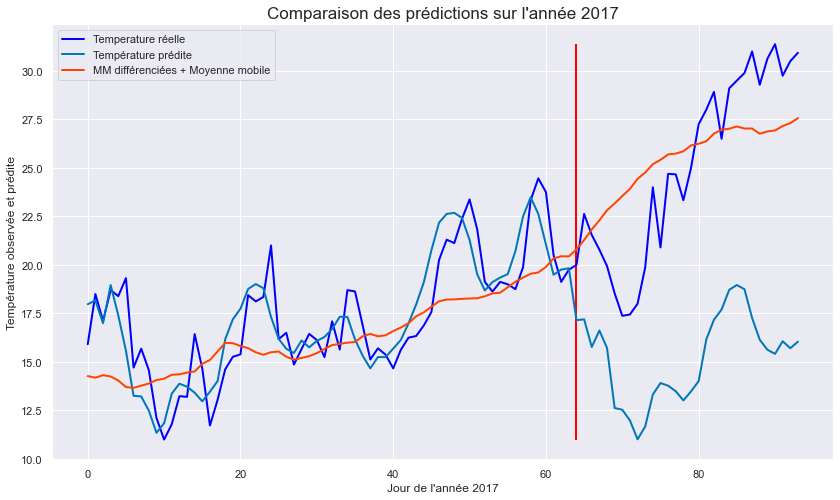

In [39]:
plt.figure(figsize = (14,8))
plt.title('Comparaison des prédictions sur l\'année 2017', fontsize = 17)

# plot observée
plot_ts(val['Time'], val['meantemp'], 'Temperature réelle', lw = 2)
# plot prédictions
plot_ts(val['Time'], convnet_forecast[:val.shape[0]], 'Température prédite', c = '#0077bb', lw = 2)
plot_ts(validation['Time'][:-20], diff_moving_avg_mm_forecast[:val.shape[0]], 
        'MM différenciées + Moyenne mobile', c = 'orangered', lw = 2)

# plot ligne verticale
plt.vlines(64, 
          ymin = min([min(convnet_forecast[:val.shape[0]]),min(val['meantemp'])]), 
          ymax = max([max(convnet_forecast[:val.shape[0]]),max(val['meantemp'])]), 
          color = 'red',
          lw = 2)

# titre des axes
plt.xlabel('Jour de l\'année 2017')
plt.ylabel('Température observée et prédite')
plt.show()

Concernant les résultats obtenus, il faut d'abord dire que je ne suis pas un expert des réseaux de neurones et qu'il aurait fallu passer plus de temps à changer les hyperparamètres, la structure du réseau et l'ajustement des optimizer et des learning rate pour obtenir des résultats vraiment optimaux. Concernant les résultats, il semblerait que le réseau de neurones à convolution (convnet) ait bien réussi à cibler les patterns de nos données. Toutefois il faudrait voir si la mauvaise prédiction à partir du 64e jour est dûe à une anomalie ou à un overfitting. Il faudrait éventuellement tester le modèle sur plus de données de validation. Concernant la moyenne mobile, elle constitue un bon estimateur de la tendance des données mais n'est pas assez précise pour prédire avec exactitude nos températures. On pourrait dire que la moyenne mobile souffre d'un biais important (elle underfit légèrement nos données car elle ne parvient pas à prédire les pics), la ou le réseau de neurone souffre d'une variance importante (ou overfitting).

## Visualisation des performances des modèles sur le train set

Lorsque l'on entraine un réseau de neurones on définit un certain nombre d'*epochs*. 1 *epoch* signifie que le réseau de neurone à essayé de prédire 1 fois l'ensemble de nos données (en ajustant ses poids pour coller le plus possible à la réalité). Logiquement, plus le nombre d'*epochs* augmente, plus l'erreur observée devrait diminuer. Nous avons ici choisi un nombre de d'*epochs* égal à 400 pour l'apprentissage de nos modèle. Nous allons voir ici une comparaison des performances des différents modèles au fil des *epochs*.

In [40]:
#%tensorboard --logdir logs/fit

In [41]:
performance.keys()

dict_keys(['Linear Regression', 'Deep Neural Network', 'Recurrent Neural Network', 'LSTM', 'Convnet'])

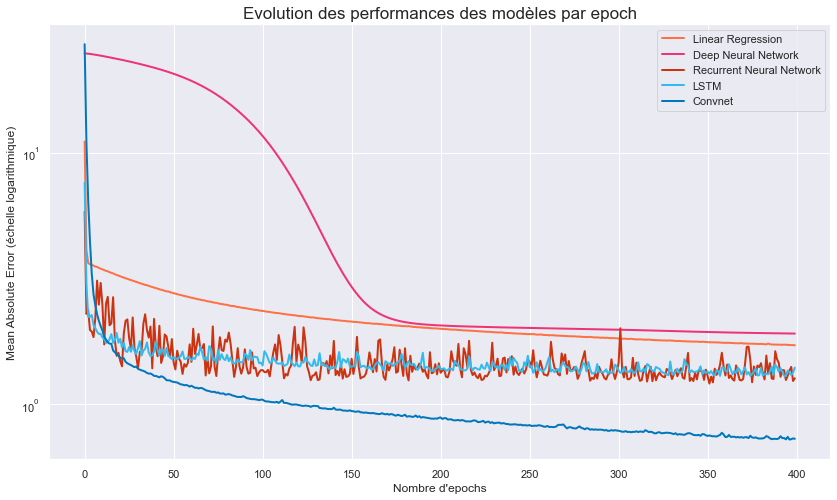

In [42]:
plt.figure(figsize = (14,8))
for k in performance.keys():
    plt.semilogy(performance[k], label = k, lw = 2, c = col[k])
plt.title('Evolution des performances des modèles par epoch', fontsize = 17)
plt.ylabel('Mean Absolute Error (échelle logarithmique)')
plt.xlabel('Nombre d\'epochs')
plt.legend()
plt.show()

Il semblerait que l'une des façons d'augmenter la performance de la régression linéaire, du DNN et du CNN serait d'augmenter le nombre d'epochs puisqu'on voit que l'on est sur une pente descendante (c'est plus flagrant pour le CNN). Faisons un zoom sur les performances des dernières epochs :

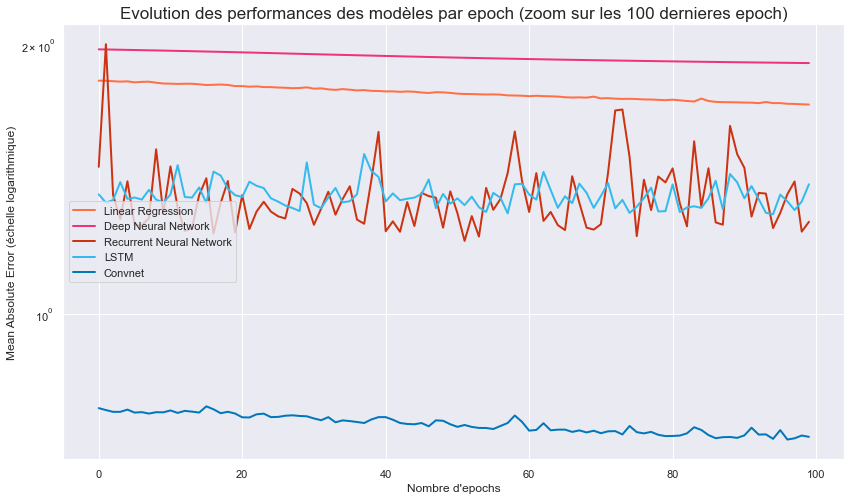

In [43]:
plt.figure(figsize = (14,8))
for k in performance.keys():
    plt.semilogy(performance[k][300:], label = k, lw = 2, c = col[k])
plt.title('Evolution des performances des modèles par epoch (zoom sur les 100 dernieres epoch)', fontsize = 17)
plt.ylabel('Mean Absolute Error (échelle logarithmique)')
plt.xlabel('Nombre d\'epochs')
plt.legend()
plt.show()